In [ ]:
#default_exp core.data

# Sneaker Finder development notebook

### version 0.1 Jan 2020
### version 0.2 Feb 2020
### version 0.3 June 2020
### version 1.0 Dec 2020 (refactor using pytorch/nbdev/fastai framework)

# OVERVIEW

This is a project initiated while an Insight Data Science fellow.  It grew out of thinking about how to make data-driven tools that could impact the fashion industry which I had been working working in.   The original over-scoped idea was to make a shoe desighn tool which could quickly develop some sneaker designs based on choosing some examples, and some text descriptors.  Designs are constrained by the "latent space" defined (discovered?) by a database of shoe images.  However, given the 3 week sprint allowed for development, I pared the tool down to a simple "aesthetic" recommender for sneakers, using the same idea of utilizing an embedding space defined by the database fo shoe images.

This is a cool reference for a fastai VAE
https://medium.com/@dhuynh95/an-introduction-to-unsupervised-learning-with-fastai-a6dbd78eca2b


In [ ]:
#hide
from fastai import *
from fastai.vision.all import *

import scipy.io as sio


In [ ]:
from snkrfinder.core import *

In [ ]:
mun

First we need to get a database of sneaker images.   The sneaker images are only 136 pixels wide, and organized by 'Category', 'SubCategory', and 'Brand'.   Additional semantic information is also available from Mechanical Turk labeling, and is available packed into matlab files.  

In [ ]:

DB_path = Path.home()/'Projects/DATABASE'
DB_path

Path('/home/ergonyc/Projects/DATABASE')

In [ ]:
!pwd

/home/ergonyc/Projects/Project2.0/snkr-finder


# Part 0: DATA

## Part 1: import the UT-Zappos50k database

untar_data

In [ ]:
# export

DB_PATH = "../../Projects/DATABASE"

def get_zappos_db():

    # don't use the "square" versions because they are excessively padded.  we'll simply pad with "white"
    #url_images = "http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip"
    url_images = "http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip"
    # the images are wider than tall with the product already taking up aproximately the whole vertical dimension
    url_meta = "http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-data.zip"

    DATA_path = Path.home()/'Projects/DATABASE'
    path_meta = untar_data(url_meta, dest=DATA_path)
    path_images = untar_data(url_images,dest=DATA_path)

## data set cleaning

The dataset is very diverse and not constructed in order to think about how popular footwear is aesthetically related.  I'm simplifying the database to include 4 categories which seem to split aesthetics for general footwear:

1) BOOTS - weatherized and/or protected footwear for work or outdoor activity
2) SANDALS - charachterized by a sole and straps
3) SHOES - generic non "boot" footwear.  includes heels and formalwear
4) SNEAKERS - atheletic / comfort inspired 

In [ ]:
#export

def read_zappos_meta():
    def _path_from_mat(fname):
        """ reads zappos imagepath from matlab file"""
        data = sio.loadmat(fname)['imagepath']
        return [i[0][0] for i in data]

    image_path = _path_from_mat(path_meta/'image-path.mat')
    df = pd.read_csv(path_meta/'meta-data.csv')

    df["path"]=image_path
    
    # ad sub-categories (one-hot)
    categories=pd.read_csv(path_meta/'meta-data-bin.csv')
    df = pd.merge(df, categories,  how='left', on='CID')# left_on=['CID'], right_on = ['CID'])


    # fix the path by remove trailing periods in folder names
    df.loc[df.path.str.contains("./",regex=False),"path"] = [i.replace("./","/") for i in df.loc[df.path.str.contains("./",regex=False),"path"]]
    df.loc[df.path.str.contains("Levi\'s ",regex=False),"path"] = [i.replace("Levi\'s ","Levis ") for i in df.loc[df.path.str.contains("Levi\'s ",regex=False),"path"]]
    # create brands and category stubs...
    df['path_and_file'] = df.path.apply(lambda path: (os.path.normpath(path)).split(os.sep) ) 
    df_to_add = pd.DataFrame(df['path_and_file'].tolist(), columns=['Category1','Category2','Brand','Filename'])

    df = df.merge(df_to_add, left_index=True, right_index=True)
    #df = pd.merge(df, df_to_add, left_index=True, right_index=True)
    return df


In [ ]:
#hide

df = read_zappos_meta()

assert (df['Category'] == df['Category1']).all()
assert (df['SubCategory'] == df['Category2']).all()


## simplify:

Categories:
    1. SHOES, 
    2. BOOTS, 
    3. "SNEAKERS", and 
    4. "SLIPPERS"

[[ TODO:  change the bullets to a short paragraph describing the simplificaiton ]]

Only include "adult" shoes
    - Adult = mens + womens (kids = not adults),+ etc (unisex)

To construct these from the Zappos I needed to pull sneakers from shoes and exclude some sub-categories.  e.g. tall boots which would drive the representation of boots.

    BOOTS:
      BOOTS
        - ankle,  mid-calf
        - exclude: knee high , over the knee , prewalker

    SANDALS:
      SANDALS
        - athletic, flat
        - exclude: heels 
        
    SHOES:
      SHOES
        - Boat shoes, clogs and mules,  flats,  loafers, oxfords, prewalker
        - exclude: heels , crib shoes , firstwalker (exclude)

    SNEAKERS
       SHOES
       - sneakers and athletic shoes

     SLIPPERS (exclude)

In [ ]:
#export

def simplify_zappos_db(df):
    " simplifies the db (df)"
    # add our "sneaker category"
    df.loc[:,'Sneakers'] = (df['Category2'] == 'Sneakers and Athletic Shoes')

    # refine boot
    df.loc[:,'Boots'] = (  (df.Category1 == 'Boots') 
                         & (df.Category2 != 'Knee High')
                         & (df.Category2 != 'Over the Knee')
                         & (df.Category2 != 'Prewalker Boots') )

    # refine shoes
    df.loc[:,'Shoes'] = (  (df.Category1 == 'Shoes') 
                         & (df.Category2 != 'Sneakers and Athletic Shoes')
                         & (df.Category2 != 'Crib Shoes')
                         & (df.Category2 != 'Firstwalker')
                         & (df.Category2 != 'Prewalker') )

    # refine shoes
    df.loc[:,'Slippers'] = (  (df.Category1 == 'Shoes') 
                         & (df.Category2 != 'Sneakers and Athletic Shoes')
                         & (df.Category2 != 'Crib Shoes')
                         & (df.Category2 != 'Firstwalker')
                         & (df.Category2 != 'Prewalker') )

    # define Slippers 
    df.loc[:,'Slippers'] = (df.Category1 == 'Slippers')
    ############
    #remove ([ 'Boys',  'Boys;Girls', 'Girls','Women;Girls', nan

    mens =  df['Gender'] == 'Men'       
    womens =  df['Gender'] == 'Women' 
    etc =  df['Gender'].str.contains('Men;', na=False)

    df.loc[:,'Adult'] = mens | womens | etc

    df.loc[:,'Mens'] = mens 
    df.loc[:,'Womens'] = womens

    df.loc[:,'OGcategory'] = df.Category
    df.loc[:,'Category'] = pd.NA

    df.loc[(df.Shoes==1),'Category'] = 'Shoes'
    df.loc[(df.Boots==1),'Category'] = 'Boots'
    df.loc[(df.Sneakers==1),'Category'] = 'Sneakers'
    df.loc[(df.Slippers==1),'Category'] = 'Slippers'

    
    # make some expository columns 
    keep_columns = ['CID','Category',
                     'path','path_and_file',
                     'Category1', 'Category2','OGcategory'
                     'Brand','Filename',
                     'Sneakers','Boots',
                     'Shoes', 'Slippers','Adult',
                     'Gender']

    df = df.filter(items=keep_columns)
    #keep Adult, Sneakers, Boots, Shoes, Slippers
    keep_rows = (df.Sneakers | df.Boots | df.Shoes| df.Slippers) & (df.Adult)
    #Only keep Adult (men+women) and Sneakers, Boots, Shoes
    df = df[keep_rows.values]
    return df

Index(['CID', 'Category', 'path', 'path_and_file', 'Category1', 'Category2',
       'Filename', 'Sneakers', 'Boots', 'Shoes', 'Slippers', 'Adult',
       'Gender'],
      dtype='object')

------------

# Save the simplified dataframe for further analysis


Also use sklearn `train_test_split` to create category stratified train/test/validate groups.  We'll keep 15 percent of our data to truly test.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#export

def skl_tt_split(df):
    "adds stratified train-validate-test via sklearn"


    X = df.index
    y = df.Category

    train_ratio = 0.70
    validation_ratio = 0.15

    # keep
    test_ratio = 0.15

    # train is now 75% of the entire data set
    # the _junk suffix means that we drop that variable completely
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio,stratify=y, random_state=666)

    # test is now 10% of the initial data set
    # validation is now 15% of the initial data set
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio),stratify=y_test, random_state=666) 
    # pack into the dataframe
    df.loc[:,'train'] = False
    df.loc[:,'test'] = False
    df.loc[:,'validate'] = False
    df.loc[:,'t_t_v'] = 'train'
    df.loc[x_train,'train'] = True
    df.loc[x_test,'test'] = True
    df.loc[x_val,'validate'] = True
    df.loc[x_test,'t_t_v'] = 'test'
    df.loc[x_val,'t_t_v'] = 'valid'
    
    

In [ ]:
# hide
# save it
filename = "zappos-50k-simplified"
#df.to_csv(f"data/{filename}.csv")
df.to_pickle(f"data/{filename}.pkl")
df.to_json(f"data/{filename}.json")

In [ ]:
# hide
df2 = df.sort_values('path', ascending=True)
df2 = df2.reset_index(drop=True)
#df4_[["CID","path","classes"]].head(5)

filename = "zappos-50k-simplified_sort"
#df.to_csv(f"data/{filename}.csv")
df2.to_pickle(f"data/{filename}.pkl")
df2.to_json(f"data/{filename}.json")

df2.head(3)

,CID,Category,path,path_and_file,Category1,Category2,Filename,Sneakers,Boots,Shoes,Slippers,Adult,Gender,train,test,validate,t_t_v
0,7965307-5291,Boots,Boots/Ankle/A. Testoni/7965307.5291.jpg,"[Boots, Ankle, A. Testoni, 7965307.5291.jpg]",Boots,Ankle,7965307.5291.jpg,False,True,False,False,True,Men,True,False,False,train
1,7999255-363731,Boots,Boots/Ankle/A. Testoni/7999255.363731.jpg,"[Boots, Ankle, A. Testoni, 7999255.363731.jpg]",Boots,Ankle,7999255.363731.jpg,False,True,False,False,True,Men,True,False,False,train
2,8000978-364150,Boots,Boots/Ankle/A. Testoni/8000978.364150.jpg,"[Boots, Ankle, A. Testoni, 8000978.364150.jpg]",Boots,Ankle,8000978.364150.jpg,False,True,False,False,True,Men,False,True,False,test


------------

# pickle the dataframe

In [ ]:
#hide

filename = "zappos-50k-simplified_sort"
#df = pd.read_csv(f"data/{filename}.csv")
df = pd.read_pickle(f"data/{filename}.pkl")
#df = pd.read_json(f"data/{filename}.json")



,CID,Category,path,path_and_file,Category1,Category2,Filename,Sneakers,Boots,Shoes,Slippers,Adult,Gender,train,test,validate,t_t_v
0,7965307-5291,Boots,Boots/Ankle/A. Testoni/7965307.5291.jpg,"[Boots, Ankle, A. Testoni, 7965307.5291.jpg]",Boots,Ankle,7965307.5291.jpg,False,True,False,False,True,Men,True,False,False,train
1,7999255-363731,Boots,Boots/Ankle/A. Testoni/7999255.363731.jpg,"[Boots, Ankle, A. Testoni, 7999255.363731.jpg]",Boots,Ankle,7999255.363731.jpg,False,True,False,False,True,Men,True,False,False,train
2,8000978-364150,Boots,Boots/Ankle/A. Testoni/8000978.364150.jpg,"[Boots, Ankle, A. Testoni, 8000978.364150.jpg]",Boots,Ankle,8000978.364150.jpg,False,True,False,False,True,Men,False,True,False,test
3,8113228-1897,Boots,Boots/Ankle/AIGLE/8113228.1897.jpg,"[Boots, Ankle, AIGLE, 8113228.1897.jpg]",Boots,Ankle,8113228.1897.jpg,False,True,False,False,True,Women,True,False,False,train
4,8113228-1912,Boots,Boots/Ankle/AIGLE/8113228.1912.jpg,"[Boots, Ankle, AIGLE, 8113228.1912.jpg]",Boots,Ankle,8113228.1912.jpg,False,True,False,False,True,Women,True,False,False,train


# ImageDataLoader instead of block API 

TODO: STASH

alternative format... just park here until i can stash it away.

In [ ]:

# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
print(torch.nn.functional.softmax(output[0], dim=0))

In [ ]:
dls = ImageDataLoaders.from_df(df, path=path_images,fn_col='path',label_col='Category',valid_pct=0.0)

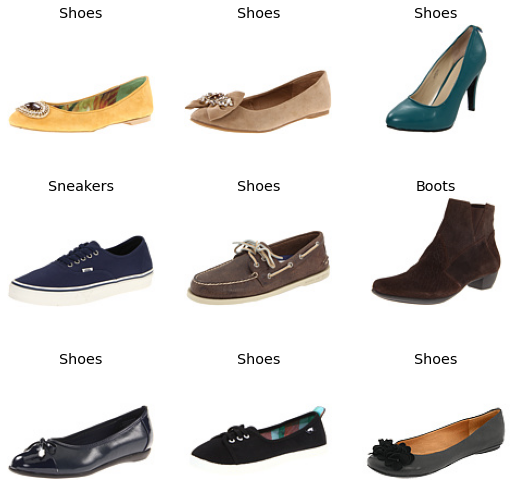

In [ ]:
dls[0].show_batch()

In [ ]:
    
tfms = aug_transforms(mult=1.0, 
               do_flip=True, 
               flip_vert=False, 
               max_rotate=5.0, 
               min_zoom=1.0, 
               max_zoom=1.05, 
               max_lighting=0.1, 
               max_warp=0.05, 
               p_affine=0.75, 
               p_lighting=0.0, 
               xtra_tfms=None, 
               size=None, 
               mode='bilinear', 
               pad_mode='reflection', 
               align_corners=True, 
               batch=False, 
               min_scale=1.0)

item_tfms = [Resize(160,method='pad', pad_mode='border')]
batch_tfms = [*tfms, Normalize.from_stats(*imagenet_stats)]
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

# put everythign in train, and don't do any augmentation since we are just going 
def get_x(r): return path_images/r['path']
def get_y(r): return r['Category']
#def get_feat(r): return r["Unnamed: 0"]
def get_feat(r): return r['path']
#def get_feat(r): return r['CID']


# resize to 160
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=IndexSplitter([]),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)  # border pads white...

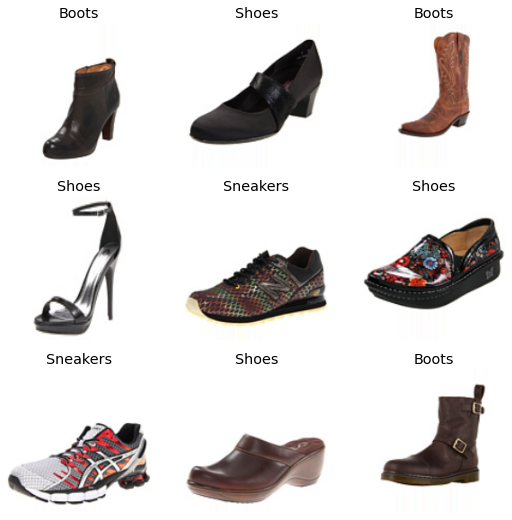

In [ ]:
dls = dblock.dataloaders(df,bs=256,drop_last=False)


dls.show_batch()